In [1]:
import cv2
import torch
import numpy as np
from collections import OrderedDict
from google.colab.patches import cv2_imshow
import dlib
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
# loading dataset
!wget http://www.cs.toronto.edu/~fidler/teaching/2018/CSC420_assign/project1.zip
!unzip /content/project1.zip

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r yolov5/requirements.txt
## Download this for 50k images 8 epoches YOLOv5 medium model
# !wget https://www.dropbox.com/s/imoqdf12v59k9ov/yolo_face_50k_8epochs.zip?dl=1

## Download this for 70k images 10 epoches YOLOv5 medium model
!wget https://www.dropbox.com/s/8atygeezg7rvyf5/best.pt?dl=1
## Use this for 70k images 10 epoches YOLOv5 medium model
!mv best.pt?dl=1 best.pt
## Use this for 70k images 10 epoches YOLOv5 medium model's weight
! python yolov5/detect.py --save-txt --weights /content/best.pt --source /content/project1/clip_3
!zip -r detect.zip /content/yolov5/runs/detect/
! zip -r clip_3_res.zip /content/yolov5/runs/detect/exp3

In [4]:
# Below code is to convert Yolo's face detection result' txt to bbox
# bbox is a dictionary with key being path to each frame and 
# value is each frames' corresponsing bounding boxes
path = '/content/yolov5/runs/detect/exp/labels' # <-- '/content/yolov5/runs/detect/expxxx/labels'
# where xxx is the path where the detected labels are stored for yolo above. 
# For example, exp5 will be /content/yolov5/runs/detect/exp5/labels

image_path = '/content/project1/clip_3' # <-- This is where clip frames are stored. Change to clip_1/2/3

dir_list = os.listdir(path)
bbox = {}
for filename in dir_list:
  f = open(os.path.join(path,filename),'r')
  lines = f.read().split('\n')
  f.close()
  img_name = filename.split('.')[0]
  img = cv2.imread(os.path.join(image_path,img_name+'.jpg'))

  if img is not None:
    boxes = []
    for line in lines:
      f = filter(None, line.split(' '))
      part = list(f)
      if len(part) > 0:
        x = float(part[1])
        y = float(part[2])
        w = float(part[3])
        h = float(part[4])
        X, Y = img.shape[1], img.shape[0]
        W = w * X
        H = h * Y
        xcenter = x * X
        ycenter = y * Y
        xmin = int(xcenter - W/2)
        ymin = int(ycenter - H/2)
        xmax = int(xcenter + W/2)
        ymax = int(ycenter + H/2)
        boxes.append((xmin, ymin, xmax, ymax))
    bbox[os.path.join(image_path,img_name+'.jpg')] = boxes

# Face Tracking Across Frames

## Method 1: Accurate Scale Estimation for Robust Visual Tracking

Here I used the method introduced in the paper ‘Accurate scale estimation for robust visual tracking.’ Proceedings of the British Machine Vision Conference BMVC. 2014. (cite). This paper uses Correlation Filter Based Tracking(https://dl.acm.org/doi/book/10.5555/2520035) with Scale Estimation so that the algorithm can track an object and draw a bounding box that will adjust the size based on the object’s size in the frame. 
Correlation Filter Based Tracking is similar to the template matching we told in the lecture, we input a frame with a bounding box, and the algorithm calculates a correlation filter based on the bounding box and then convolves the correlation filter in the next frame to find the pixel with a peak. The paper uses an additional algorithm to compute correlation filters with different sizes, so the algorithm is able to handle large-scale variations.

We implemented it using dlib.correlation_tracker. This function is an implementation of the algorithm above.

We designed our algorithm as follows:

Loop over all the frames in order, and keep a list of dlib.correlation_tracker for each bounding box. If there is no tracker, then we run the face detection algorithm and obtain the bounding box for that frame. After getting bounding boxes for that frame, for each bounding box, we initialize correlation_tracker by inputting the frame and the bounding box. Then we keep tracking for all the following frames and evaluate the Peak To Sidelobe Ratio. This ratio is a metric that measures the peak sharpness of the correlation plane. If the ratio is lower than a threshold, then we abandon that tracker and assign all the bounding boxes that the tracker assigned for each frame belongs to same person (I assign an unique id for each person associated with the bounding box). Until we abandon all the trackers, we run the face detection algorithm and do the things above again.



In [5]:
clip_img_paths = []
for file in Path(image_path).iterdir():
    if ".jpg" in file.name:
        clip_img_paths.append(file)
clip_img_paths = sorted(clip_img_paths, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

In [6]:
img_paths = clip_img_paths

# Count how many face detection is runned
count_face_detection = 0
# Ordered dict to save a list of detected faces each time
# {id: (tracker, [(frame_id, bounding_box), ...])}
all_faces = {}
# finished_tracking_faces to store all the finished traked person ID's
# bounding boxes
finished_tracking_faces = {}
next_face_id = 0
# Hyperparameter
face_detection_prob_boundary = 0.8
PSR_boundary = 7

frames_with_face_detection = set(bbox.keys())
import time
# Record time
start = time.time()

# Record the number of people that are currently tracking
# If become zero then we need to run face detection again
num_of_tracking = 0
for i in range(len(img_paths)):
  curr_path = str(img_paths[i])
  if curr_path in frames_with_face_detection:
    curr_img = cv2.imread(str(curr_path))
    # If we are not tracking any faces
    if num_of_tracking == 0:
      # Run face detection to get face bounding boxes
      boxes = bbox[str(curr_path)]
      count_face_detection += 1
      num_of_boxes = len(boxes)
      for j in range(num_of_boxes):
        # initialize tracking process
        curr_box = boxes[j]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]
        new_tracker = dlib.correlation_tracker()
        new_tracker.start_track(curr_img,dlib.rectangle(left_up_pt[0],
                      left_up_pt[1],
                      righ_dow_pt[0],
                      righ_dow_pt[1]))
        # Add new tracking face to face dictionary
        
        all_faces[next_face_id] = (new_tracker, [(curr_path, left_up_pt, righ_dow_pt)])
        next_face_id += 1
        num_of_tracking += 1
        
    else:
      key_list = all_faces.keys()
      keys_to_pop = []
      for key in key_list:
        tracker = all_faces[key][0]
        trackingQuality = tracker.update(curr_img)
        # http://dlib.net/python/index.html#dlib.correlation_tracker
        """
        The Peak to Sidelobe Ratio (PSR) is a metric that measures
        the peak sharpness of the correlation plane. For the 
        estimation of the PSR the peak is located first. Then the mean
        and standard deviation of the 20X20 sidelobe region -
        excluding a 5X5 central mask centred at the peak are
        computed. PSR is then calculated as follows:
        (compues how unique the centre is)
        """
        if trackingQuality >= PSR_boundary:
          tracked_position = tracker.get_position()
          t_x = int(tracked_position.left())
          t_y = int(tracked_position.top())
          t_w = int(tracked_position.width())
          t_h = int(tracked_position.height())
          left_up_pt = (t_x, t_y)
          righ_dow_pt = (t_x + t_w , t_y + t_h)
          all_faces[key][1].append((curr_path, left_up_pt, righ_dow_pt))
        else:# the face is not being tracked, move to finished tracking ordered dic
          finished_tracking_faces[key] = all_faces[key][1]
          keys_to_pop.append(key)
          num_of_tracking -= 1
      for key in keys_to_pop:
        all_faces.pop(key)

# Move all face tracking from all_faces　to finished_tracking_faces to
# move all the faces that tracked to last frame
for key in all_faces.keys():
  finished_tracking_faces[key] = all_faces[key][1]


# Record time
end = time.time()
print("time takes: ", end - start)
print("face detection times: ", count_face_detection)

time takes:  4.3610804080963135
face detection times:  7


In [7]:
# Draw bounding boxes based on the tracks and save them to save_frames
# save_frames format: {"frame_paths":open_cv_image}
save_frames = {}
for key in finished_tracking_faces.keys():
  for box in finished_tracking_faces[key]:
    frame_path = box[0]
    # Read image from path only if we have not draw bbox on it
    if frame_path in save_frames.keys():
      curr_img = save_frames[frame_path]
    else:
      curr_img = cv2.imread(str(frame_path))
    left_up_pt = box[1]
    righ_dow_pt = box[2]
    # Draw bbox
    image_drew_box = cv2.rectangle(curr_img,left_up_pt,
              righ_dow_pt, (36,255,12), 1)
    # Draw person id
    cv2.putText(image_drew_box, str(key), (int(left_up_pt[0]), int(left_up_pt[1])-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
    save_frames[frame_path] = image_drew_box

# Since nota all frames has a bounding box
# here we save those frames without bounding box to save_frames
frames_with_bbox = set(save_frames.keys())
for path in img_paths:
  if str(path) not in frames_with_bbox:
    curr_img = cv2.imread(str(path))
    save_frames[str(path)] = curr_img


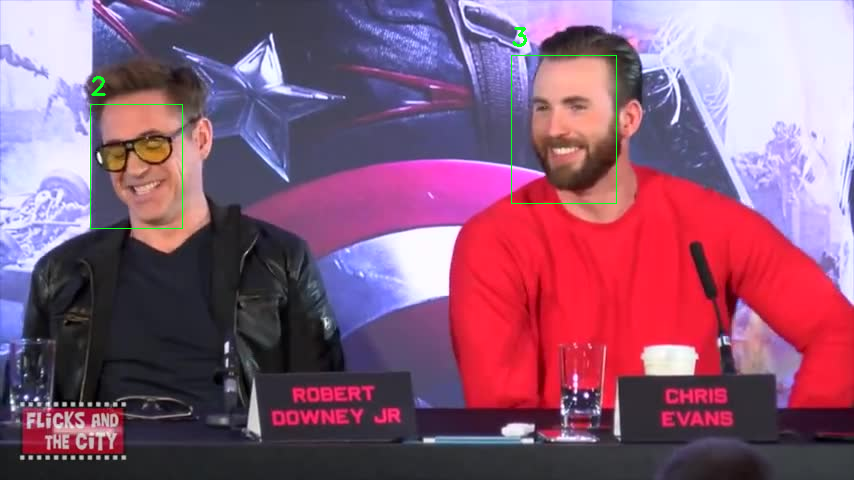

In [8]:
cv2_imshow(save_frames[list(save_frames.keys())[22]])

In [9]:
outpath = './content/result_clip_3'
if not os.path.isdir(outpath):
  os.makedirs(outpath)
for frame in save_frames:
    fname = os.path.split(frame)[-1]
    cv2.imwrite(os.path.join(outpath, fname),save_frames[frame])

In [ ]:
!ffmpeg -framerate 10 -pattern_type glob -i ./content/result_clip_3/'*.jpg' \
  -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"\
  -c:v libx264 -pix_fmt yuv420p out3.mp4

# Method 2 Compare the similarity between two frames bounding boxes and/or their content

Inspired by the shot detection algorithm, we can compare all the bounding boxes within a frame to all the bounding boxes in the following frame, and if they are similar or in a similar position, then we can say those two bounding boxes bound the same person. I tried to use two ways of calculating the similarity of the two bounding boxes:

1. Centroid of the bounding box.
2. Histogram differences between two bounding boxes' content.

Algorithm:

Loop over all the frames in increasing order. Inside the loop, run the face detection algorithm and obtain bounding boxes. Loop over all those bounding boxes and compare them to previous frames bounding boxes. If no previous frame existed or previous frames have no bounding box, then assign a unique person ID to each bounding box. If the previous frame existed, then compute the distance between this frame's bounding boxes and the previous frame's bounding boxes.
1. If two frames contain the same amount of bounding boxes or the current frame contains fewer bounding boxes, then assign the existing bounding box to the bounding box's ID in the previous frame, which two bounding boxes have the smallest distance. 
2. If the current frame has more bounding boxes after all the previous frame's bounding boxes' id has been assigned. We assign a new person ID for all the rest of the current frame's bounding boxes.

In [11]:
"""
Score functions to compare two bounding boxes and/or its content
"""
def histogram_differences(curr, prev, curr_bbox, prev_bbox, color_mode="rgb"):
    """
    The function will return histogram differences
    
    """
    # Crop each image
    img1 = curr[int(curr_bbox[1]):int(curr_bbox[3]), int(curr_bbox[0]):int(curr_bbox[2])]
    img2 = prev[int(prev_bbox[1]):int(prev_bbox[3]), int(prev_bbox[0]):int(prev_bbox[2])]
    # Calculate histogram difference
    if color_mode=="rgb":
      bgr_split_img1 = cv2.split(img1)
      bgr_split_img2 = cv2.split(img2)
      sum_hist_diff = 0
      for i in range(3):
          hist_img1 = cv2.calcHist([bgr_split_img1[i]], [0], None, [256], [0, 256])
          hist_img2 = cv2.calcHist([bgr_split_img2[i]], [0], None, [256], [0, 256])
          cv2.normalize(hist_img1, hist_img1, norm_type=cv2.NORM_MINMAX)
          cv2.normalize(hist_img2, hist_img2, norm_type=cv2.NORM_MINMAX)
          hist_diff = np.sum(np.abs(np.array(hist_img1) - np.array(hist_img2)))
          sum_hist_diff  = sum_hist_diff + hist_diff
      return sum_hist_diff/3.0
    else:
      raise ValueError('Invalid color_mode')
def centroid_dist(curr, prev, curr_bbox, prev_bbox):
  """
  Compute the distance between two bounding box's centroid
  curr: current frame image
  prev: current frame image
  curr_bbox: one bounding box of the current frame
  prev_bbox: one bounding box of the current frame
  """
  curr_bbox_centroid = (curr_bbox[2]+curr_bbox[0])/2, (curr_bbox[3]+curr_bbox[1])/2
  prev_bbox_centroid = (prev_bbox[2]+prev_bbox[0])/2, (prev_bbox[3]+prev_bbox[1])/2
  dist = np.linalg.norm(np.array(curr_bbox_centroid)-np.array(prev_bbox_centroid))
  return dist

In [12]:
def compute_distance(dist_function, curr, prev, bboxs_curr, bboxs_prev, boundary=50):
  """
  Using dist_function compute the distance between two set of bounding boxes
  bboxs_curr, bboxs_prev,
  between two frames
  curr, prev,
  """
  # [(bbox1_index, [dist1, dist2...]), ()]
  bbox_dist = []
  bboxs_curr_assigned = []
  # Compute distance
  for bbox1_index in range(len(bboxs_curr)):
    dists = []
    for bbox2_index in range(len(bboxs_prev)):
      dist = dist_function(curr, prev, bboxs_curr[bbox1_index], bboxs_prev[bbox2_index])
      dists.append(dist)
    if dists == []:
      dists = [float('inf')]
    bbox_dist.append((bbox1_index, dists))

  bbox_dist.sort(key=lambda s: min(s[1]))

  # Assign index to each current frame's bounding boxes
  # If No prev box id to be assigned then assign None
  assigned_indexes = []
  for item in bbox_dist:
    bbox1_index = item[0]
    dists = item[1]
    # To prevent assigned a previously occurred value
    for i in assigned_indexes:
      dists[i] = float('inf')
    min_dist_bbox2_index = np.argmin(dists)
    assigned_indexes.append(min_dist_bbox2_index)
    # If assigned then set the distance to infinity
    if dists[min_dist_bbox2_index] == float('inf'):
      min_dist_bbox2_index = None
    # If distance exceed boundary
    elif dists[min_dist_bbox2_index] >= boundary:
      min_dist_bbox2_index = None
    bboxs_curr_assigned.append((bbox1_index,min_dist_bbox2_index))
  return bboxs_curr_assigned



In [13]:
img_paths = clip_img_paths
face_detection_result = bbox
# Ordered dict to save a list of detected faces each time
# {id: (tracker, [(frame_id, bounding_box), ...])}
dist_function = centroid_dist
# Difference boundary for centroid_dist and histogram_differences
boundary = 50

all_faces = {}
next_face_id = 0

# All the frames with face bounding boxes
frames_with_face_detection = set(face_detection_result.keys())

# Record time
start = time.time()

# Record the number of people that are currently tracking
# If become zero then we need to run face detection again
num_of_tracking = 0
prev_path = None
prev_img = None
bboxs_prev = []
# Loop over all frames
for i in range(len(img_paths)):
  curr_path = str(img_paths[i])
  if curr_path in frames_with_face_detection:
    curr_img = cv2.imread(str(curr_path))
    # Run face detection
    boxes = face_detection_result[str(curr_path)]
    num_of_boxes = len(boxes) # If no face detected

    assigned_indexies = []
    if num_of_boxes > 0:
      # Compute assignment when current frame has boxes
      assignment = compute_distance(dist_function,curr_img, prev_img, boxes, bboxs_prev)

      all_faces[curr_path] = {}
      curr_bboxes_indexes = set(range(len(boxes)))
      for item in assignment:
        bbox1_index = item[0]
        assigned_indexies.append(bbox1_index)
        curr_box = boxes[bbox1_index]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]

        min_dist_bbox2_index = item[1]
        # Case 2 if prev has more boxes
        # Case 3 if they are equal
        # Assign/ingerit previous box's ID 
        if min_dist_bbox2_index is not None:
          prev_box = bboxs_prev[min_dist_bbox2_index]
          prev_left_up_pt = prev_box[0], prev_box[1]
          prev_righ_dow_pt = prev_box[2], prev_box[3]
          prev_box = prev_left_up_pt, prev_righ_dow_pt
          prev_assigned_id = all_faces[prev_path][prev_box]
          box_pt = left_up_pt, righ_dow_pt
          all_faces[curr_path][box_pt] = prev_assigned_id
        # Case 1 if curr has more boxes, 
        # Assign new face ID
        else:
          box_pt = left_up_pt, righ_dow_pt
          all_faces[curr_path][box_pt] = next_face_id
          next_face_id += 1
      # assign all the curr bounding boxes with distance 
      # larger than boundary
      unassigned_indecies = curr_bboxes_indexes.difference(set(assigned_indexies))
      for unassigned_i in unassigned_indecies:
        curr_box = boxes[unassigned_i]
        left_up_pt = curr_box[0], curr_box[1]
        righ_dow_pt = curr_box[2], curr_box[3]
        box_pt = left_up_pt, righ_dow_pt
        all_faces[curr_path][box_pt] = next_face_id
        next_face_id += 1
      bboxs_prev = boxes
    else:
      all_faces[curr_path] = {}
      bboxs_prev = []
    
    prev_path = curr_path
    prev_img = curr_img
# Record time
end = time.time()
print("time takes: ", end - start)

time takes:  1.0520153045654297


In [18]:
# Draw bounding boxes based on the tracks and save to some place
save_frames = {}
for key in all_faces.keys():
  frame_path = key
  curr_img = cv2.imread(str(frame_path))
  for box in all_faces[key].keys():
    left_up_pt = box[0]
    righ_dow_pt = box[1]
    image_drew_box = cv2.rectangle(curr_img,left_up_pt,
              righ_dow_pt, (36,255,12), 1)
    cv2.putText(image_drew_box, str(all_faces[key][box]), (int(left_up_pt[0]), 
          int(left_up_pt[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12), 2)
    save_frames[frame_path] = image_drew_box

# Since nota all frames has a bounding box
# here we save those frames without bounding box to save_frames
frames_with_bbox = set(save_frames.keys())
for path in img_paths:
  if str(path) not in frames_with_bbox:
    curr_img = cv2.imread(str(path))
    save_frames[str(path)] = curr_img


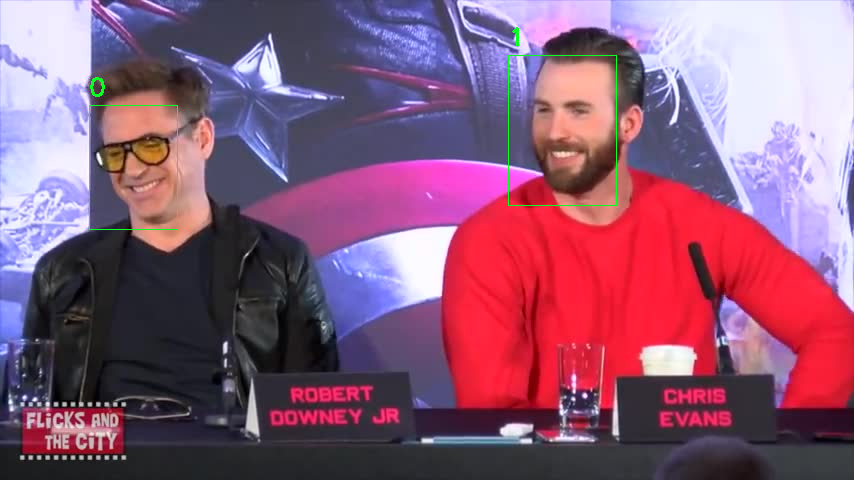

In [19]:
cv2_imshow(save_frames[list(save_frames.keys())[22]])

In [16]:
outpath = './content/result_clip_3_method2'
if not os.path.isdir(outpath):
  os.makedirs(outpath)
for frame in save_frames:
    fname = os.path.split(frame)[-1]
    cv2.imwrite(os.path.join(outpath, fname),save_frames[frame])

In [ ]:
!ffmpeg -framerate 10 -pattern_type glob -i ./content/result_clip_3_method2/'*.jpg' \
  -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"\
  -c:v libx264 -pix_fmt yuv420p out3_method2.mp4